In [2]:
import csv
import pickle
import time
import warnings
from collections import defaultdict, Counter
from datetime import timedelta
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tqdm import tqdm

warnings.filterwarnings('ignore')
torch.manual_seed(0)

### Storing information

In [3]:
storing_path = Path('./results')
SAVE = True

# LRP tools

## LRP core layers

In [4]:
from typing import Any
from torch.nn.modules import Module
import torch
from torch import nn as nn
import copy


def stabilize(z):
    return z + ((z == 0.).to(z) + z.sign()) * 1e-6


def modified_layer(
        layer,
        transform
):
    """
    This function creates a copy of a layer and modify
    its parameters based on a transformation function 'transform'.
    -------------------

    :param layer: a layer which its parameters are going to be transformed.
    :param transform: a transformation function.
    :return: a new layer with modified parameters.
    """
    new_layer = copy.deepcopy(layer)

    try:
        new_layer.weight = torch.nn.Parameter(transform(layer.weight.float()))
    except AttributeError as e:
        print(e)

    try:
        new_layer.bias = torch.nn.Parameter(transform(layer.bias.float()))
    except AttributeError as e:
        print(e)

    return new_layer


class ModifiedLinear(Module):
    def __init__(
            self,
            fc: torch.nn.Linear,
            transform: Any,
            zero_bias: bool = False
    ):
        """
        A wrapper to make torch.nn.Linear explainable.
        -------------------

        :param fc: a fully-connected layer (torch.nn.Linear).
        :param transform: a transformation function to modify the layer's parameters.
        :param zero_bias: set the layer's bias to zero. It is useful when checking the conservation property.
        """
        super(ModifiedLinear, self).__init__()
        self.fc = fc

        if zero_bias:
            self.fc.bias = torch.nn.Parameter(torch.zeros(self.fc.bias.shape))

        self.transform = transform
        self.modified_fc = modified_layer(layer=fc, transform=transform)

    def forward(
            self,
            x: torch.Tensor
    ) -> torch.Tensor:
        z = self.fc(x)
        zp = self.modified_fc(x)
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()


class ModifiedLinearDiff(Module):
    def __init__(
            self,
            fc: torch.nn.Linear,
            transform: Any,
            zero_bias: bool = False
    ):
        """
        A wrapper to make torch.nn.Linear explainable.
        -------------------

        :param fc: a fully-connected layer (torch.nn.Linear).
        :param transform: a transformation function to modify the layer's parameters.
        :param zero_bias: set the layer's bias to zero. It is useful when checking the conservation property.
        """
        super(ModifiedLinearDiff, self).__init__()
        self.fc = fc

        self.fc_diff = copy.deepcopy(fc)
        self.fc_diff.weight = torch.nn.Parameter(self.fc_diff.weight - self.fc_diff.weight[[1, 0]])
        if self.fc.bias is not None:
            self.fc_diff.bias = torch.nn.Parameter(torch.zeros(self.fc.bias.shape))

        self.transform = transform
        self.modified_fc = modified_layer(layer=self.fc_diff, transform=transform)

    def forward(
            self,
            x: torch.Tensor
    ) -> torch.Tensor:
        z = self.fc(x)
        zp = self.modified_fc(x)
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()

class ModifiedAct(Module):
    def __init__(
            self,
            act: Any
    ):
        """
       A wrapper to make activation layers such as torch.nn.Tanh or torch.nn.ReLU explainable.
       -------------------

       :param act: an activation layer (torch.nn.Tanh or torch.nn.ReLU).
       """
        super(ModifiedAct, self).__init__()
        self.modified_act = nn.Identity()
        self.act = act

    def forward(
            self,
            x
    ):
        z = self.act(x)
        zp = self.modified_act(x)
        zp = stabilize(zp)
        return (zp.double() * (z.double() / zp.double()).data.double()).float()


class ModifiedLayerNorm(Module):
    def __init__(
            self,
            norm_layer: torch.nn.LayerNorm,
            eps: float = 1e-12,
            zero_bias: bool = False
    ):
        super(ModifiedLayerNorm, self).__init__()
        if zero_bias:
            norm_layer.bias = torch.nn.Parameter(torch.zeros(norm_layer.bias.shape))

        self.norm_layer = norm_layer
        self.weight = norm_layer.weight
        self.bias = norm_layer.bias
        self.eps = eps

    def forward(
            self,
            input: torch.Tensor
    ) -> torch.Tensor:

        z = self.norm_layer(input)
        mean = input.mean(dim=-1, keepdim=True)
        var = torch.var(input, unbiased=False, dim=-1, keepdim=True)
        denominator = torch.sqrt(var + self.eps)
        denominator = denominator.detach()
        zp = ((input - mean) / denominator) * self.weight + self.bias
        zp = stabilize(zp)
        return zp * (z / zp).data

## LRP rules

In [5]:
from torch import Tensor


def gamma(
        gam: float = 0.2
) -> Tensor:
    def modify_parameters(parameters: Tensor):
        return parameters + (gam * parameters.clamp(min=0))

    return modify_parameters

# Data utils

## Load data

In [6]:
dataset = pd.read_csv('df_tree.csv')
dataset = dataset.drop(columns=['G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10', 'G11', 'G12', 'GLa'])
data_top = dataset.keys()

feature_names = data_top[1:-1]
X = dataset.iloc[:, 1:-1].values.astype('int')
y = dataset.iloc[:, -1].values.astype('int')

dataset

Unnamed: 0     Ba     Ca     Ce     Co     Cs     Cu     Eu     Fe  \
0        Li-K-Mn/MgO  False  False  False  False  False  False  False  False   
1       Li-Fe-Tb/MgO  False  False  False  False  False  False  False   True   
2       Li-Fe-Hf/MgO  False  False  False  False  False  False  False   True   
3     Na-Na-none/MgO  False  False  False  False  False  False  False  False   
4        Na-Ni-Y/MgO  False  False  False  False  False  False  False  False   
..               ...    ...    ...    ...    ...    ...    ...    ...    ...   
286  Sr-Cs-none/CeO2  False  False  False  False   True  False  False  False   
287  Sr-Ce-none/CeO2  False  False   True  False  False  False  False  False   
288     Y-Zr-Eu/CeO2  False  False  False  False  False  False   True  False   
289    Mo-Pd-Ba/CeO2   True  False  False  False  False  False  False  False   
290    Cs-Ce-Nd/CeO2  False  False   True  False   True  False  False  False   

        Hf  ...  Al2O3    BaO    CaO   CeO2  La2O3    MgO   SiO2   TiO2  \
0    False  ...  False  False  False  False  False   True  False  False   
1    False  ...  False  False  False  False  False   True  False  False   
2     True  ...  False  False  False  False  False   True  False  False   
3    False  ...  False  False  False  False  False   True  False  False   
4    False  ...  False  False  False  False  False   True  False  False   
..     ...  ...    ...    ...    ...    ...    ...    ...    ...    ...   
286  False  ...  False  False  False   True  False  False  False  False   
287  False  ...  False  False  False   True  False  False  False  False   
288  False  ...  False  False  False   True  False  False  False  False   
289  False  ...  False  False  False   True  False  False  False  False   
290  False  ...  False  False  False   True  False  False  False  False   

      ZrO2  Positive  
0    False     False  
1    False     False  
2    False     False  
3    False     False  
4    False     False  
..     ...       ...  
286  False     False  
287  False     False  
288  False     False  
289  False     False  
290  False     False  

[291 rows x 38 columns]

In [7]:
dataset_pos = dataset.iloc[y == True,].values.astype('bool')
dataset_neg = dataset.iloc[y == False,].values.astype('bool')
X_pos = dataset_pos[:, 1:-1]
y_pos = dataset_pos[:, -1]
X_neg = dataset_neg[:, 1:-1]
y_neg = dataset_neg[:, -1]

In [8]:
def stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs):
    X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size=0.2, random_state=rs)
    X_neg_train, X_neg_test, y_neg_train, y_neg_test = train_test_split(X_neg, y_neg, test_size=0.2, random_state=rs)
    X_train = np.concatenate((X_pos_train, X_neg_train), axis=0)
    y_train = np.concatenate((y_pos_train, y_neg_train), axis=0)
    X_test = np.concatenate((X_pos_test, X_neg_test), axis=0)
    y_test = np.concatenate((y_pos_test, y_neg_test), axis=0)
    return X_train, y_train, X_test, y_test

In [9]:
def resampling(X, y, overratio, underratio, randomstate):
    X = X.astype(int)
    y = y.astype(int)
    over = SMOTE(sampling_strategy=overratio,
                 random_state=randomstate)  # set this value to get similar sample size before and after resampling
    under = RandomUnderSampler(sampling_strategy=underratio,
                               random_state=randomstate)  # to get equal sample sizes of two classes
    steps = [('o', over), ('u', under)]
    pipeline = Pipeline(steps=steps)
    # transform the dataset
    X, y = pipeline.fit_resample(X, y)
    X = X.astype(bool)
    y = y.astype(bool)
    return X, y

In [10]:
class CatalystDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __getitem__(self, index):
        data = self.X[index]
        label = self.y[index]

        return data, label

    def __len__(self):
        return len(self.X)

## Model utils

## Build model

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(
            self,
            num_layers=3,
            num_neurons_per_layer=[36, 128, 128, 2],
            dropout_rate=0,
            bias=True,
            layer_norm=False,
            output_tanh=False,
            artificial_neuron=False,

    ):
        super().__init__()

        self.num_layers = num_layers
        self.num_neurons_per_layer = num_neurons_per_layer
        self.dropout_rate = dropout_rate
        self.layer_norm = layer_norm
        self.output_tanh = None
        self.artificial_neuron = artificial_neuron

        layers = []
        layer_norms = []
        for i in range(self.num_layers - 1):
            layers.append(nn.Linear(self.num_neurons_per_layer[i], self.num_neurons_per_layer[i + 1], bias=bias))
            if self.layer_norm:
                layer_norms.append(nn.LayerNorm(self.num_neurons_per_layer[i + 1]))

        if self.artificial_neuron:
            layers.append(nn.Linear(self.num_neurons_per_layer[-2], self.num_neurons_per_layer[-1], bias=False))
        else:
            layers.append(nn.Linear(self.num_neurons_per_layer[-2], self.num_neurons_per_layer[-1], bias=bias))

        self.dropout = nn.Dropout(p=dropout_rate)
        self.layers = nn.ModuleList(layers)
        self.layer_norms = nn.ModuleList(layer_norms)
        self.act = nn.ReLU()
        if output_tanh:
            self.output_tanh = nn.Tanh()

    def forward(self, x):
        out = self.dropout(x)
        for i, layer in enumerate(self.layers):
            out = layer(out)
        
            if i != self.num_layers - 1:
                out = self.act(out)
                if self.layer_norm:
                    out = self.layer_norms[i](out)
        if self.output_tanh is not None:
            out = self.output_tanh(out) + 1
        return out

## Build modified model

Here, we create a wrapper for the original model using LRP layers.

In [12]:
class ModifiedNeuralNetwork(nn.Module):
    def __init__(self, net):
        super(ModifiedNeuralNetwork, self).__init__()

        self.num_layers = net.num_layers
        self.num_neurons_per_layer = net.num_neurons_per_layer
        self.dropout_rate = net.dropout_rate
        self.layer_norm = net.layer_norm
        self.output_tanh = net.output_tanh
        self.artificial_neuron = net.artificial_neuron

        layers = []
        layer_norms = []
        for layer in net.layers[:-1]:
            layers.append(ModifiedLinear(fc=layer, transform=gamma()))
        if net.artificial_neuron:
            layers.append(ModifiedLinearDiff(fc=net.layers[-1], transform=gamma()))
        else:
            layers.append(ModifiedLinear(fc=net.layers[-1], transform=gamma()))

        for layer_norm in net.layer_norms:
            mod_ln = ModifiedLayerNorm(norm_layer=layer_norm)
            layer_norms.append(mod_ln)

        self.dropout = net.dropout
        self.layers = nn.ModuleList(layers)
        self.layer_norms = nn.ModuleList(layer_norms)
        self.act = ModifiedAct(net.act)
        if self.output_tanh is not None:
            self.output_tanh = ModifiedAct(net.output_tanh)

    def forward(self, x):
        out = self.dropout(x)
        for i, layer in enumerate(self.layers):
            out = layer(out)

            if i != self.num_layers - 1:
                out = self.act(out)
                if self.layer_norm:
                    out = self.layer_norms[i](out)
        if self.output_tanh is not None:
            out = self.output_tanh(out) + 1
        return out

    def relevance_act(self, x):
        if self.artificial_neuron:
            out = self.dropout(x)
            for i, layer in enumerate(self.layers[:-1]):
                out = layer(out)
                out = self.act(out)
                if self.layer_norm:
                    out = self.layer_norms[i](out)
            zp = out.unsqueeze(1) * self.layers[-1].modified_fc.weight.unsqueeze(0)
            z = out.unsqueeze(1) * self.layers[-1].fc.weight.unsqueeze(0)
            zp = stabilize(zp)
            out = (zp.double() * (z.double() / zp.double()).data.double()).float()
            return out
        else:
            return self.forward(x)

In [13]:
def lrp(model, X, target):
    X = (X * 1).data
    X.requires_grad_(True)
    X.grad = None

    # Get the relevance scores.
    output = model.forward(X)

    pred = torch.argmax(output, dim=1)

    if target is None:
        (output[..., 1] - output[..., 0]).sum().backward()
    else:
        (output * target).sum().backward()

    # (output).sum().backward()
    relevance = (X.grad * X).data

    output = model.relevance_act(X)

    return relevance, pred, output


"""
preactivation

pred = layer(preactivation)
pred.sum().backward()
grad = preactivation.grad
relevance = grad x preactivation / normalisation x upperrelevance

"""

'\npreactivation\n\npred = layer(preactivation)\npred.sum().backward()\ngrad = preactivation.grad\nrelevance = grad x preactivation / normalisation x upperrelevance\n\n'

# Cross validation architecture

In [14]:
num_layers = [2, 3, 4]
num_neurons_per_layers = {
    1: [[36, 16, 2], [36, 32, 2], [36, 64, 2], [36, 128, 2]], 
    2:[[36, 16, 16, 2], [36, 32, 32, 2], [36, 64, 64, 2], [36, 128, 128, 2]],
    3: [[36, 16, 16, 16, 2], [36, 32, 32, 32, 2], [36, 64, 64, 64, 2], [36, 128, 128, 128, 2]]
}
dropout_rates = [0, 0.1]
#dropout_rates = [0, 0.05, 0.1, 0.15, 0.2]
#lr = [1e-2, 1e-3, 1e-4, 1e-5]
#wd = [0, 1e-4, 1e-5]
lr = [1e-3]
wd = [0.5e-2]
all_combs = []

for i in range(len(num_layers)):
    for v in list(num_neurons_per_layers.values())[i]:
        for p in dropout_rates:
            for l in lr:
                for w in wd:
                    combs = []
                    combs.append(num_layers[i])
                    combs.append(v)
                    combs.append(p)
                    combs.append(l)
                    combs.append(w)
                    all_combs.append(combs)

print(f"All combinations ({len(all_combs)}): \n{all_combs}")

#all_combs = all_combs[0:50]  # TODO: remove it was just for testing

All combinations (24): 
[[2, [36, 16, 2], 0, 0.001, 0.005], [2, [36, 16, 2], 0.1, 0.001, 0.005], [2, [36, 32, 2], 0, 0.001, 0.005], [2, [36, 32, 2], 0.1, 0.001, 0.005], [2, [36, 64, 2], 0, 0.001, 0.005], [2, [36, 64, 2], 0.1, 0.001, 0.005], [2, [36, 128, 2], 0, 0.001, 0.005], [2, [36, 128, 2], 0.1, 0.001, 0.005], [3, [36, 16, 16, 2], 0, 0.001, 0.005], [3, [36, 16, 16, 2], 0.1, 0.001, 0.005], [3, [36, 32, 32, 2], 0, 0.001, 0.005], [3, [36, 32, 32, 2], 0.1, 0.001, 0.005], [3, [36, 64, 64, 2], 0, 0.001, 0.005], [3, [36, 64, 64, 2], 0.1, 0.001, 0.005], [3, [36, 128, 128, 2], 0, 0.001, 0.005], [3, [36, 128, 128, 2], 0.1, 0.001, 0.005], [4, [36, 16, 16, 16, 2], 0, 0.001, 0.005], [4, [36, 16, 16, 16, 2], 0.1, 0.001, 0.005], [4, [36, 32, 32, 32, 2], 0, 0.001, 0.005], [4, [36, 32, 32, 32, 2], 0.1, 0.001, 0.005], [4, [36, 64, 64, 64, 2], 0, 0.001, 0.005], [4, [36, 64, 64, 64, 2], 0.1, 0.001, 0.005], [4, [36, 128, 128, 128, 2], 0, 0.001, 0.005], [4, [36, 128, 128, 128, 2], 0.1, 0.001, 0.005]]


# Train, test, and explanation

## Helper functions

In [15]:
def get_data_loaders(X_pos, X_neg, y_pos, y_neg, rs, with_resampling=True, verbose=False):
    """This method creates the train, validation, and test data loaders for a given split (rs). If resapling is set to False, the data is not resampled."""
    X_train, y_train, X_test, y_test = stratified_sampling(X_pos, X_neg, y_pos, y_neg, rs)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=rs)
    if with_resampling:
        X_train, y_train = resampling(X_train, y_train, overratio=0.6, underratio=1, randomstate=123)
    if verbose:
        print(f"Random seed {rs}")
        print(f"Train data shape: {X_train.shape}, {y_train.shape}")
        print(f"Validation data shape: {X_val.shape}, {y_val.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    catalyst_dataset_train = CatalystDataset(X_train, y_train)
    catalyst_dataset_val = CatalystDataset(X_val, y_val)
    catalyst_dataset_test = CatalystDataset(X_test, y_test)

    train_loader = torch.utils.data.DataLoader(catalyst_dataset_train)
    val_loader = torch.utils.data.DataLoader(catalyst_dataset_val)
    test_loader = torch.utils.data.DataLoader(catalyst_dataset_test, shuffle=False)
    return train_loader, val_loader, test_loader

In [16]:
def train_epoch(train_loader, model, criterion, optimizer):
    for i_train, (x_train, y_train) in enumerate(train_loader):
        x_train = torch.tensor(x_train).to(next(model.parameters()))
        y_train = torch.nn.functional.one_hot(torch.tensor(y_train).long(), 2).to(x_train)
        optimizer.zero_grad()

        logits_train = model(x_train.float())

        loss = criterion(torch.nn.Softmax()(logits_train), y_train)
        loss.backward()
        optimizer.step()

        # pred_probab_train = nn.Softmax(dim=1)(logits_train)
        # y_pred_train = pred_probab_train.argmax(1)


def val_epoch(val_loader, model):
    val_pred = []
    val_gt = []
    for i_val, (x_val, y_val) in enumerate(val_loader):
        x_val = torch.tensor(x_val).to(next(model.parameters()))
        y_val = torch.nn.functional.one_hot(torch.tensor(y_val).long(), 2).to(x_val)

        logits_val = model(x_val.float())
        pred_probab_val = nn.Softmax(dim=1)(logits_val)
        y_pred_val = pred_probab_val.argmax(1)

        val_pred.append(y_pred_val.item())
        val_gt.append(y_val.argmax(1).item())
    return val_pred, val_gt


def inference_test(model, mod_model, test_loader):
    pred = []
    out = []
    gt = []
    rels = defaultdict(list)
    confusion_scores = defaultdict(list)
    confusion_idxs = defaultdict(list)

    for i, (x, y) in tqdm(enumerate(test_loader)):
        x = torch.tensor(x).to(next(model.parameters()))
        y = torch.tensor(y).long()  # Assuming y is already in the appropriate form

        logits = model(x)
        pred_probab = nn.Softmax(dim=1)(logits)
        y_pred = pred_probab.argmax(1)  # Get the predicted class

        pred.append(y_pred.item())
        gt.append(y.item())  # Directly use y since it's already the class label

        x = x.detach().cpu()
        # Perform LRP analysis
        R_on_pred, _, _ = lrp(mod_model, x,
                           nn.functional.one_hot(y, num_classes=2).float())  # One-hot encoding for LRP if necessary
        if mod_model.artificial_neuron:
            R_on_pos_cls, _, lrp_out = lrp(mod_model, x, torch.tensor([[0, 1]]))
            lrp_out = lrp_out[:, 1]
        else:
            R_on_pos_cls, _, lrp_out = lrp(mod_model, x, None)
        rels['R_on_pred'].append(R_on_pred.numpy().flatten())
        rels['R_on_pos_cls'].append(R_on_pos_cls.numpy().flatten())

        out.append(lrp_out.numpy(force=True).squeeze())

        # Evaluate and sort scores by outcome
        if y_pred == y:
            if y_pred.item() == 0:
                confusion_scores['true_neg_scores'].append(pred_probab[0, 0].item())
                confusion_idxs['true_neg_idx'].append(i)
            else:
                confusion_scores['true_pos_scores'].append(pred_probab[0, 1].item())
                confusion_idxs['true_pos_idx'].append(i)
        else:
            if y_pred.item() == 0:
                confusion_scores['false_neg_scores'].append(pred_probab[0, 0].item())
                confusion_idxs['false_neg_idx'].append(i)
            else:
                confusion_scores['false_pos_scores'].append(pred_probab[0, 1].item())
                confusion_idxs['false_pos_idx'].append(i)
    return pred, gt, out, rels, confusion_scores, confusion_idxs

In [17]:
def get_formatted_results(acc, f1, precision, recall, model_name, verbose=True):
    mean_acc, std_acc = np.mean(acc), np.std(acc)  # mean and std over different data splits
    mean_f1, std_f1 = np.mean(f1), np.std(f1)
    mean_precision, std_precision = np.mean(precision), np.std(precision)
    mean_recall, std_recall = np.mean(recall), np.std(recall)

    if verbose:
        table_data_mlp = [
            ('Metric', 'Mean', 'Standard Deviation'),
            ('Accuracy', mean_acc, std_acc),
            ('F1 Score', mean_f1, std_f1),
            ('Precision', mean_precision, std_precision),
            ('Recall', mean_recall, std_recall)
        ]
        print(tabulate(table_data_mlp, headers='firstrow', tablefmt='fancy_grid'))

    data = {
        'Model': model_name,
        'Accuracy_Mean': mean_acc,
        'Accuracy_Std': std_acc,
        'F1_Mean': mean_f1,
        'F1_Std': std_f1,
        'Precision_Mean': mean_precision,
        'Precision_Std': std_precision,
        'Recall_Mean': mean_recall,
        'Recall_Std': std_recall
    }
    return data

In [18]:
def custom_palette(arr):
    """Create a custom color palette based on the relevance scores."""
    min_val = min(arr)
    max_val = max(arr)
    n_colors = len(arr) * 2

    if min_val >= 0:  # Only red part
        return list(sns.color_palette("coolwarm", n_colors=n_colors)[len(arr):])
    elif max_val <= 0:  # Only blue part
        return list(sns.color_palette("coolwarm", n_colors=n_colors)[:len(arr)])
    else:
        num_negative = len([x for x in arr if x <= 0])
        num_positive = len(arr) - num_negative

        palette = []
        if num_negative > num_positive:
            # More negative values, assign blue to more portion
            blue_part = int(num_negative / len(arr) * n_colors)
            palette.extend(sns.color_palette("coolwarm", n_colors=blue_part)[:num_negative])
            palette.extend(sns.color_palette("coolwarm", n_colors=n_colors - blue_part)[len(arr) - num_negative:])
        else:
            # More positive values, assign red to more portion
            red_part = int(num_positive / len(arr) * n_colors)
            palette.extend(sns.color_palette("coolwarm", n_colors=n_colors - red_part)[:len(arr) - num_positive])
            palette.extend(sns.color_palette("coolwarm", n_colors=red_part)[num_positive:])

        return palette

## based on the positive class [0,1]

In [19]:
with_resampling = True

In [21]:
# This explenation is based on the positive class [0,1]
criterion = nn.BCELoss()
acc = 0
n = 100  # TODO increase
n_iter = 20  # TODO increase
patience = 10  # TODO increase between 5 and 10 
verbose = True
bias = True
layer_norm = False
out_act = False
act_rel = True

In [ ]:
acc_mlp_g = []
precision_mlp_g = []
recall_mlp_g = []
f1_mlp_g = []

selected_models_max_g = defaultdict(list)  # For storing the selected model architecture and its F1 score for each split
selected_models_g = defaultdict(list)  # For storing the all model architecture and its F1 score for each split
selected_models_counts_g = Counter()  # For storing counts and F1 scores of selected models across splits

split_test_data = {}  # Store confusion information and relevance scores for each split

for rs in range(n):
    print(f"Split {rs}")
    start_time = time.time()
    ### Get the data loaders for the current split

    train_loader, val_loader, test_loader = get_data_loaders(X_pos, X_neg, y_pos, y_neg, rs,
                                                             with_resampling=with_resampling, verbose=verbose)

    ### Iterate over all combinations of hyperparameters for given split and select the best-performing model
    max_f1_model = None  # Model with max validation F1 score
    max_f1_val = 0  # Max validation F1 score

    convergences = []
    idx_max_f1_model = 0
    for k, comb in enumerate(all_combs):
        if k % 50 == 0:
            print(f"> Combination {k}/{len(all_combs)}")

        num_layers, num_neurons_per_layer, dropout_rate, lr, wd = comb

        model = NeuralNetwork(num_layers, num_neurons_per_layer, dropout_rate, bias=bias,
                              layer_norm=layer_norm, output_tanh=out_act, artificial_neuron=act_rel)
        if torch.cuda.is_available():
            model = model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), weight_decay=wd, lr=lr)
        criterion = nn.BCELoss()

        early_stopping_counter = 0
        best_val_f1 = 0
        f1_val = 0
        iteration = 0

        # iterate n_iter epochs
        for iteration in tqdm(range(n_iter), desc=f"Training for max {n_iter} epochs", leave=False):

            model.train()
            train_epoch(train_loader, model, criterion, optimizer)

            model.eval()
            val_pred, val_gt = val_epoch(val_loader, model)

            f1_val = f1_score(np.array(val_gt), np.array(val_pred))

            if f1_val > best_val_f1:
                best_val_f1 = f1_val
                early_stopping_counter = 0
            else:
                early_stopping_counter += 1

            if early_stopping_counter >= patience:
                break

        # Store epoch that the model converged
        convergences.append(iteration)
        # Store the selected model architecture and its F1 score for this split
        model_architecture = str(model)  # Convert the model architecture to a string
        selected_models_g[model_architecture].append(f1_val)

        # Store the model for given combination if it has a higher F1 score
        if best_val_f1 >= max_f1_val:
            max_f1_model = copy.deepcopy(model)
            max_f1_val = best_val_f1
            idx_max_f1_model = k

    ### Store model architecture that achieved the highest F1 score over all combinations for 1 split
    model_architecture_max = str(max_f1_model)  # Convert the model architecture to a string
    selected_models_max_g[model_architecture_max].append(max_f1_val)
    # Increase counter for the selected model architecture
    selected_models_counts_g[model_architecture_max] += 1
    max_f1_model.cpu()

    ### Evaluate the best-performing model on the test set.
    max_f1_model.eval()
    modified_model = ModifiedNeuralNetwork(max_f1_model)

    pred, gt, out, rels, confusion_scores, confusion_idxs = inference_test(max_f1_model, modified_model, test_loader)
    gt = np.array(gt)
    pred = np.array(pred)
    out = np.array(out)

    split_test_data[rs] = {
        'pred': pred,
        'gt': gt,
        'out': out,
        'rels': rels,
        # rels is a dict, containing the keys R_on_pred and R_on_pos_cls, each of which is a list of numpy arrays
        'confusion_scores': confusion_scores,
        # confusion_scores is a dict, containing the keys true_pos_scores, true_neg_scores, false_pos_scores, and false_neg_scores, each of which is a list of floats
        'confusion_idxs': confusion_idxs,
        # confusion_idxs is a dict, containing the keys true_pos_idx, true_neg_idx, false_pos_idx, and false_neg_idx, each of which is a list of integers
        'convergence_times': convergences,
        # store number of epochs until convergence for each combination of hyperparameters
        'convergence_time_max_f1_model': convergences[idx_max_f1_model]
        # store number of epochs until convergence for the model with the highest F1 score
    }

    acc_mlp_g.append(accuracy_score(gt, pred))
    precision_mlp_g.append(precision_score(gt, pred, zero_division=1))
    recall_mlp_g.append(recall_score(gt, pred))
    f1_mlp_g.append(f1_score(gt, pred))

    print(f"> Total computation time for split {rs}: {timedelta(seconds=(time.time() - start_time))}\n")

In [112]:
selected_models_counts_g

Counter({'NeuralNetwork(\n  (dropout): Dropout(p=0, inplace=False)\n  (layers): ModuleList(\n    (0): Linear(in_features=36, out_features=16, bias=True)\n    (1): Linear(in_features=16, out_features=2, bias=False)\n  )\n  (layer_norms): ModuleList()\n  (act): ReLU()\n)': 13,
         'NeuralNetwork(\n  (dropout): Dropout(p=0.1, inplace=False)\n  (layers): ModuleList(\n    (0): Linear(in_features=36, out_features=16, bias=True)\n    (1-2): 2 x Linear(in_features=16, out_features=16, bias=True)\n    (3): Linear(in_features=16, out_features=2, bias=False)\n  )\n  (layer_norms): ModuleList()\n  (act): ReLU()\n)': 10,
         'NeuralNetwork(\n  (dropout): Dropout(p=0.1, inplace=False)\n  (layers): ModuleList(\n    (0): Linear(in_features=36, out_features=16, bias=True)\n    (1): Linear(in_features=16, out_features=2, bias=False)\n  )\n  (layer_norms): ModuleList()\n  (act): ReLU()\n)': 10,
         'NeuralNetwork(\n  (dropout): Dropout(p=0.1, inplace=False)\n  (layers): ModuleList(\n    (0

#### Store all results

In [72]:
if SAVE:
    with open(storing_path / f'all_results_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.pkl', 'wb') as f:
        pickle.dump(split_test_data, f)

#### Format and save the metrics

In [63]:
data_mlp = get_formatted_results(acc_mlp_g, f1_mlp_g, precision_mlp_g, recall_mlp_g, 'Neural Networks', verbose=True)
if SAVE:
    file_path = f'mlp_metrics_lrp_bias_{bias}_art_neuron_{act_rel}_wd_{wd}_NoResampling.csv'
    with open(storing_path / file_path, 'w', newline='') as file:
        writer = csv.DictWriter(file, fieldnames=data_mlp.keys())
        writer.writeheader()
        writer.writerow(data_mlp)

╒═══════════╤════════╤══════════════════════╕
│ Metric    │   Mean │   Standard Deviation │
╞═══════════╪════════╪══════════════════════╡
│ Accuracy  │    nan │                  nan │
├───────────┼────────┼──────────────────────┤
│ F1 Score  │    nan │                  nan │
├───────────┼────────┼──────────────────────┤
│ Precision │    nan │                  nan │
├───────────┼────────┼──────────────────────┤
│ Recall    │    nan │                  nan │
╘═══════════╧════════╧══════════════════════╛


In [70]:
file_path = f'mlp_metrics_lrp_bias_{bias}_art_neuron_{act_rel}_wd_{wd}_NoResampling.csv'
with open(storing_path / file_path, 'r', newline='') as file:
    reader = csv.DictReader(file)
    for row in reader:
        print('row', row)

row {'Model': 'Neural Networks', 'Accuracy_Mean': 'nan', 'Accuracy_Std': 'nan', 'F1_Mean': 'nan', 'F1_Std': 'nan', 'Precision_Mean': 'nan', 'Precision_Std': 'nan', 'Recall_Mean': 'nan', 'Recall_Std': 'nan'}


In [39]:
ratio_pos2neg = []
for key in split_test_data.keys():
    split = split_test_data[key]
    split_array = np.array(split['rels']['R_on_pos_cls'])

    pos_element = np.sum(split_array[split_array > 0])
    neg_element = np.sum(np.abs(split_array[split_array < 0]))
    #print(f"pos/neg: {pos_element/neg_element}")
    ratio_pos2neg.append(pos_element/neg_element)
print("ratio mean: ", np.mean(ratio_pos2neg))

ratio mean:  0.17958611


# Read a saved data

In [23]:
wd = wd[0]
# file_path_to_read = '/Users/parastoo/phd_projects/OCM/results/analysis_with_data_resampling/all_results_wBias_NoLayerNorm.pkl'
file_path_to_read = storing_path / f'all_results_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.pkl'
with open(file_path_to_read, 'rb') as f:
    split_test_data = pickle.load(f)

## Create visualizations

In [24]:
# Sample a random split from all results, i.e., random key of split_test_data dictionary
np.random.seed(1)
rs = np.random.choice(list(split_test_data.keys()))
single_sample_split_rs = rs

print(f"Randomly selected split: {rs}\n")

confusion_scores = split_test_data[rs]['confusion_scores']
confusion_idxs = split_test_data[rs]['confusion_idxs']
rels = split_test_data[rs]['rels']
outs = split_test_data[rs]['out']

#print('Keys of different subdictionaries:')
#print(confusion_scores.keys())
#print(confusion_idxs.keys())
#print(rels.keys())

Randomly selected split: 37



In [25]:
def get_highest_and_lowest_scores(scores, idxs, top_k=1, bottom_k=1):
    """For each confusion category, get the highest and lowest scoring samples and their indexes."""
    # Convert score lists to numpy arrays for easier indexing
    scores = np.array(scores)
    idxs = np.array(idxs)

    # Sorting indices
    sort_idx = np.argsort(scores)

    # High and low scores
    high_scores = scores[sort_idx[-top_k:]]
    high_idxs = idxs[sort_idx[-top_k:]]

    low_scores = scores[sort_idx[:bottom_k]]
    low_idxs = idxs[sort_idx[:bottom_k]]

    return high_scores, high_idxs, low_scores, low_idxs

index_lists = []
score_lists = []
out_lists = []
categories = []
name_mapping = {
    'true_pos_scores': 'True Positives',
    'false_pos_scores': 'False Positives',
    'true_neg_scores': 'True Negatives',
    'false_neg_scores': 'False Negatives'
}

# Desired order
desired_order = [
    'High True Positives', 'Low True Positives',
    'High False Positives', 'Low False Positives',
    'High False Negatives', 'Low False Negatives',
    'High True Negatives', 'Low True Negatives'
]

temp_categories = []
temp_index_lists = []
temp_score_lists = []
temp_out_lists = []

for ((scores_key, scores), (idx_key, idxs)) in zip(confusion_scores.items(), confusion_idxs.items()):
    high_scores, high_idxs, low_scores, low_idxs = get_highest_and_lowest_scores(scores, idxs, top_k=1, bottom_k=1)

    temp_categories.append(f"High {name_mapping[scores_key]}")
    temp_index_lists.append(high_idxs)
    temp_score_lists.append(high_scores)
    temp_out_lists.append(outs[high_idxs])

    temp_categories.append(f"Low {name_mapping[scores_key]}")
    temp_index_lists.append(low_idxs)
    temp_score_lists.append(low_scores)
    temp_out_lists.append(outs[low_idxs])

# Sorting the results to match the desired order
for category in desired_order:
    index = temp_categories.index(category)
    categories.append(temp_categories[index])
    index_lists.append(temp_index_lists[index])
    score_lists.append(temp_score_lists[index])
    out_lists.append(temp_out_lists[index])

categories

['High True Positives',
 'Low True Positives',
 'High False Positives',
 'Low False Positives',
 'High False Negatives',
 'Low False Negatives',
 'High True Negatives',
 'Low True Negatives']

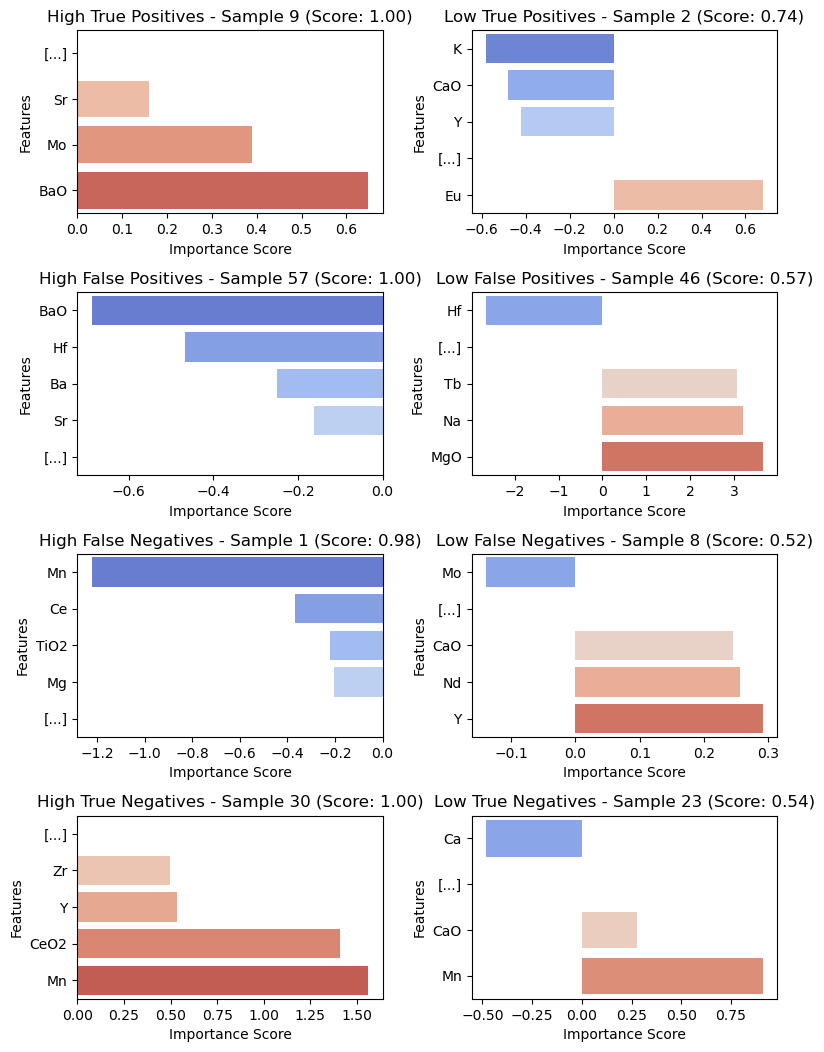

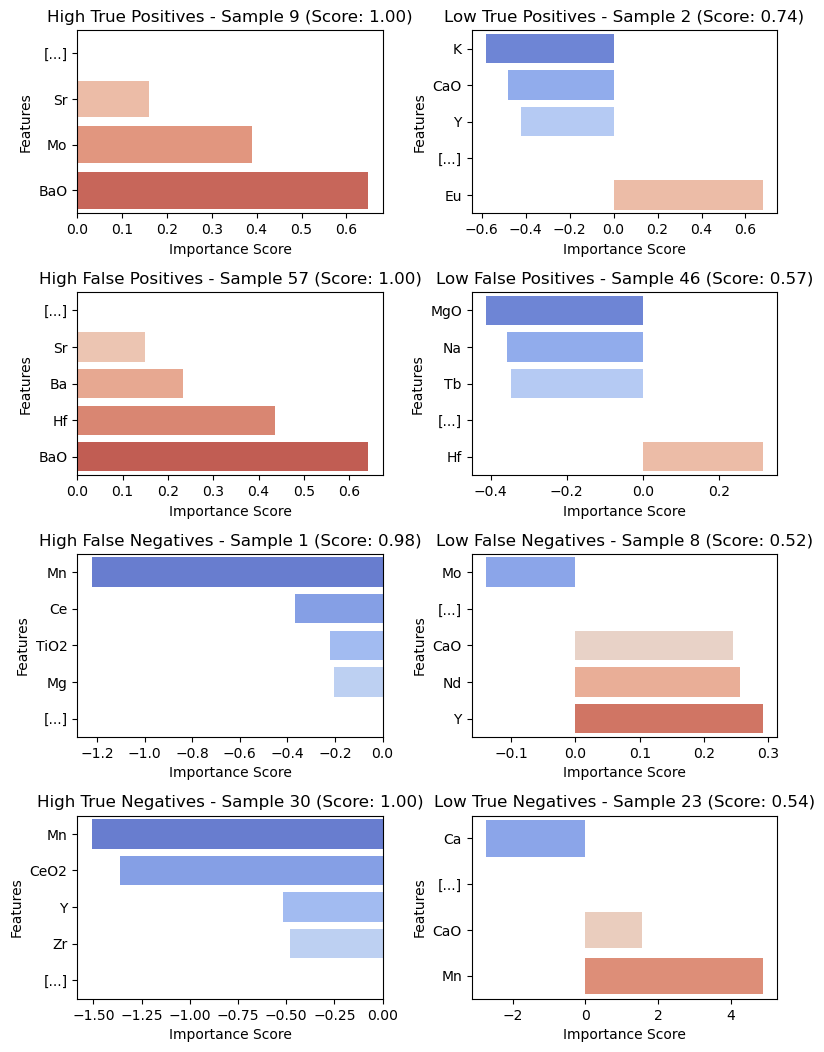

In [26]:
## Visualize the relevance scores for the highest and lowest scoring samples per category
# figsize=(8.27, 11.69) is A4 paper size -> lets make it a bit smaller
for rel_key, rels_list in rels.items():
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10.95))
    axes = axes.flatten()
    for k, (index_list, score_list, out_list, category) in enumerate(zip(index_lists, score_lists, out_lists, categories)):
        idx = index_list[0]
        score = score_list[0]
        out = out_list[0]
        rels_single_sample = rels_list[idx]  # Is a list with feature relevance scores for given sample

        df_single_sample = pd.DataFrame({
            'Feature': feature_names,
            'Importance Score': rels_single_sample
        }).sort_values(by='Importance Score', ascending=True)

        # Find the index of the first zero value
        zero_index = df_single_sample['Importance Score'].eq(0).idxmax()

        df_single_sample = df_single_sample[
            ~((df_single_sample['Importance Score'] == 0) & (df_single_sample.index != zero_index))]
        df_single_sample.loc[zero_index, 'Feature'] = '[...]'

        palette = custom_palette(df_single_sample['Importance Score'])

        sns.barplot(x='Importance Score', y='Feature', data=df_single_sample, palette=palette, ax=axes[k])
        axes[k].set_title(f"{category} - Sample {idx} (Score: {score:.2f})", fontsize=12)
        axes[k].set_xlabel('Importance Score')
        axes[k].set_ylabel('Features')
    # fig.suptitle(
    #     f"Feature Importance Scores for Highest and Lowest Scoring Samples\n(Relevances computed w.r.t. {'prediction' if 'pred' in rel_key else 'the positive class'})",
    #     fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if SAVE:
        plt.savefig(
            storing_path / f"LRP_on_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}_samples_per_cat.png",
            dpi=300, facecolor=(1, 1, 1, 0),
            bbox_inches='tight')
    plt.show(fig)

# Average Feature Importance

In the following we would like to understand the average feature importance based on the relevance scores. We compute it over all splits and samples and for both methods of relevance computation.

# Without rebalencing factor

Relevance scores for R_on_pos_cls shape: (100, 59, 36) (n_splits, n_samples, n_features)


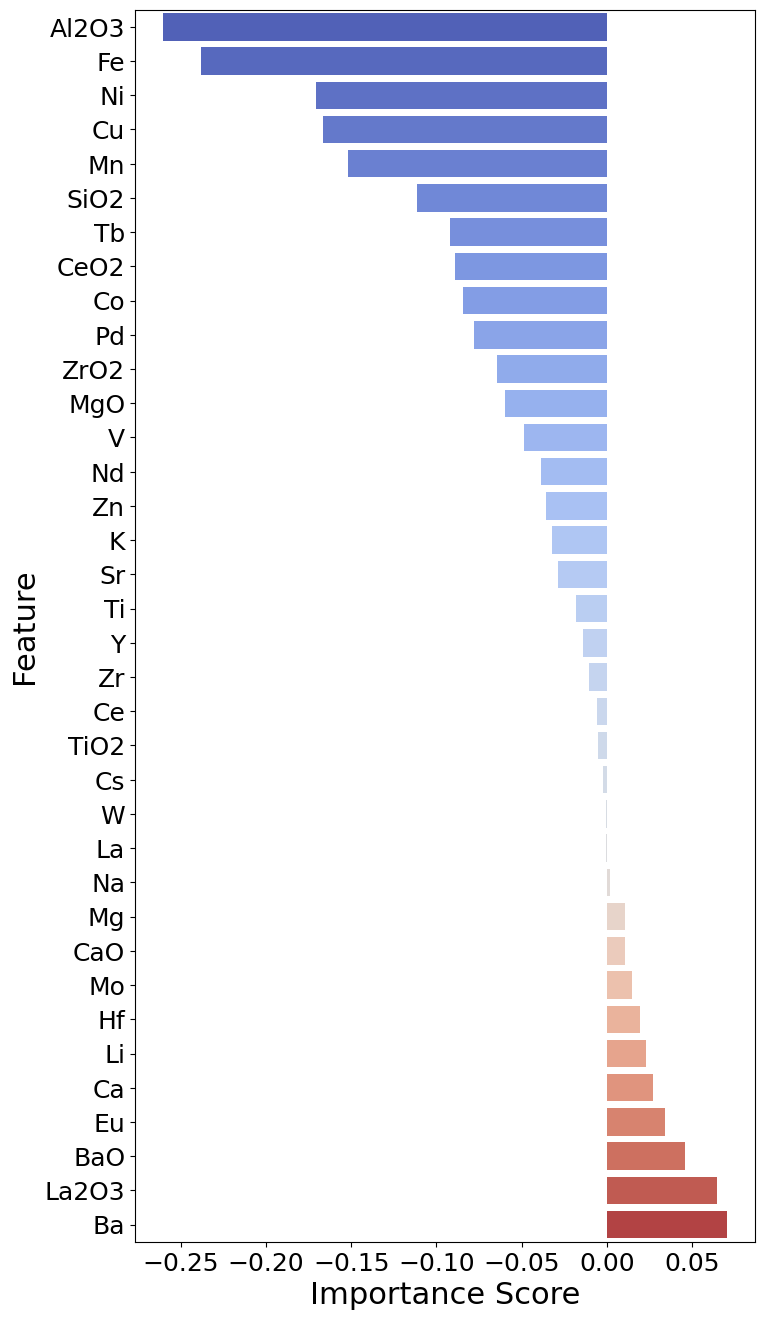

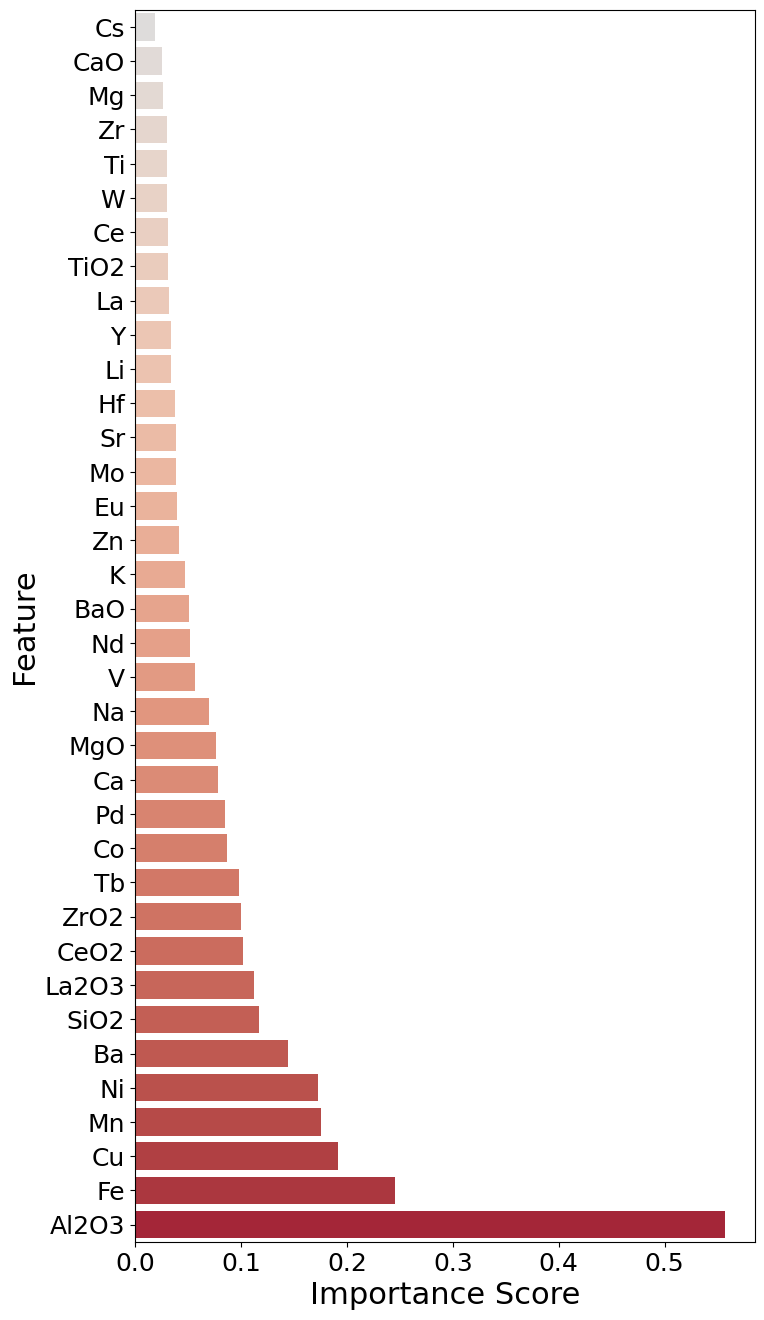

In [114]:
for rel_key in ['R_on_pos_cls']:

    rels_per_split_n_sample = np.array([rs_data['rels'][rel_key] for rs, rs_data in split_test_data.items()])
    if verbose:
        print(
            f"Relevance scores for {rel_key} shape: {rels_per_split_n_sample.shape} (n_splits, n_samples, n_features)")

    # flatten the array such that the rows are all samples over all splits
    flattened_array = rels_per_split_n_sample.reshape(-1, rels_per_split_n_sample.shape[-1])

    # compute mean relevance over all samples and splits
    mean_relevance = flattened_array.mean(axis=0)
    mean_abs_relevance = np.abs(flattened_array).mean(axis=0)

    df_feature_importance_nn = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': mean_relevance,
    })

    # store mean feature importances 
    if SAVE:
        file_path_nn = f"feature_importance_nn_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.csv"
        df_feature_importance_nn.to_csv(storing_path / file_path_nn, index=False)

    df_feature_importance_sorted = df_feature_importance_nn.sort_values(by='Importance Score', ascending=True)

    # Plot the sorted feature importance
    plt.figure(figsize=(8, 16))
    palette = custom_palette(df_feature_importance_sorted['Importance Score'])

    sns.barplot(x='Importance Score', y='Feature', data=df_feature_importance_sorted, palette=palette)
    #plt.title(
    #    f"Feature Importance in Neural Networks (LRP based on the {'prediction with Bias No Layer Norm' if 'pred' in rel_key else 'positive class with Bias No Layer Norm'})")
    plt.xlabel('Importance Score', fontsize=22)
    plt.ylabel('Feature', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if SAVE:
        plt.savefig(
            storing_path / f"feature_importance_nn_{'prediction' if 'pred' in rel_key else 'positive'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0),
            bbox_inches='tight')
    plt.show()

    # Plot the absolute values of the sorted feature importance
    df_feature_importance_nn_abs = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': mean_abs_relevance,
    })

    df_feature_importance_nn_abs_sorted = df_feature_importance_nn_abs.sort_values(by='Importance Score',
                                                                                   ascending=True)

    plt.figure(figsize=(8, 16))
    palette = custom_palette(df_feature_importance_nn_abs_sorted['Importance Score'])

    sns.barplot(x='Importance Score', y='Feature', data=df_feature_importance_nn_abs_sorted, palette=palette)
    #plt.title(
    #    f"Absolute Feature Importance in Neural Networks (LRP based on the {'prediction' if 'pred' in rel_key else 'positive class'})")
    plt.xlabel('Importance Score', fontsize=22)
    plt.ylabel('Feature', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if SAVE:
        plt.savefig(
            storing_path / f"feature_importance_nn_abs_{'prediction' if 'pred' in rel_key else 'positive'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0), bbox_inches='tight')
    plt.show()

        # store mean feature importances 
    if SAVE:
        file_path_nn = f"feature_importance_nn_abs_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.csv"
        df_feature_importance_nn.to_csv(storing_path / file_path_nn, index=False)

    df_feature_importance_sorted = df_feature_importance_nn.sort_values(by='Importance Score', ascending=True)

In [80]:
ratio_pos2neg = []
for key in split_test_data.keys():
    split = split_test_data[key]
    split_array = np.array(split['rels']['R_on_pos_cls'])

    pos_element = np.sum(split_array[split_array > 0])
    neg_element = np.sum(np.abs(split_array[split_array < 0]))
    #print(f"pos/neg: {pos_element/neg_element}")
    ratio_pos2neg.append(pos_element/neg_element)
print("ratio mean: ", np.mean(ratio_pos2neg))

ratio mean:  0.33385962


In [27]:
# NEW Rebalancing
def rescale_relevance(relevance_scores, classif_scores):
    """
    Rescale relevance scores to have the same amount of relevance as model output
    Args: 
        relevance_scores: relevance scores
        classif_scores: model output
        mode: 0 if relevance is balanced based on both positive and negative contributions,
              1 if relevance is balanced based on positive class
              -1 if relevance is balanced based on negative class
    Returns:
        relevance scores_rescale: rescaled relevance scores
    """

    pos_rel_mask = (relevance_scores > 0).astype(float)
    neg_rel_mask = (relevance_scores <= 0).astype(float)
    sum_pos_rel = (pos_rel_mask * relevance_scores).sum(1, keepdims=True)
    sum_neg_rel = (neg_rel_mask * np.abs(relevance_scores)).sum(1, keepdims=True)

    # if not using final ReLU, shift scores so all are positive

    # if not np.all(classif_scores >= 0):
    #     shifted_classif_scores = classif_scores - np.min(classif_scores) - 1e-10
    # else:
    #     shifted_classif_scores = classif_scores * 1

    rescale_fac = np.zeros_like(relevance_scores).astype(float)
    # center classifier scores

    sum_pos_fac = pos_rel_mask * (classif_scores[:, [1]] / (sum_pos_rel + 1e-10))
    sum_neg_fac = neg_rel_mask * (classif_scores[:, [0]] / (sum_neg_rel + 1e-10))
    rescale_fac += sum_pos_fac
    rescale_fac += sum_neg_fac

    relevance_scores_rescale = relevance_scores * rescale_fac

    print('relevance scores sum, relevance scores rescale sum, sum pos rel, sum neg_rel, classif scores 1, classif_scores 0')
    print('all scores array', np.concatenate([relevance_scores.sum(1, keepdims=True),
                                              relevance_scores_rescale.sum(1, keepdims=True),
                                              sum_pos_rel,
                                              sum_neg_rel,
                                              classif_scores[:, [1]],
                                              classif_scores[:, [0]]], axis=1))

    return relevance_scores_rescale

In [28]:
rels_per_split_n_sample = np.array([rs_data['rels']['R_on_pos_cls'] for _, rs_data in split_test_data.items()])
print('rels per split shape', rels_per_split_n_sample.shape)
rels_per_split_n_sample = np.reshape(rels_per_split_n_sample, (-1, rels_per_split_n_sample.shape[-1]))
print('rels per split shape', rels_per_split_n_sample.shape)
outs = [rs_data['out'].squeeze() for _, rs_data in split_test_data.items()]
if outs[0].shape[-1] > 2:
    out_per_split_n_sample = np.zeros((len(outs),) + outs[0].shape[:-1] + (2, ))
    print('out per split shape', out_per_split_n_sample.shape)
    for i in range(len(outs)):
        pos_out_mask = (outs[i] > 0).astype(float)
        neg_out_mask = (outs[i] <= 0).astype(float)
        sum_pos_out = (pos_out_mask * outs[i]).sum(-1)
        sum_neg_out = (neg_out_mask * np.abs(outs[i])).sum(-1)
        out_per_split_n_sample[i] = np.stack([sum_neg_out, sum_pos_out], axis=-1)

else:
    out_per_split_n_sample = np.array(outs)
print('out per split shape', out_per_split_n_sample.shape)
out_per_split_n_sample = np.reshape(out_per_split_n_sample, (-1, out_per_split_n_sample.shape[-1]))
print('out per split shape', out_per_split_n_sample.shape)

print('rels shape', rels_per_split_n_sample.shape)
print('outs shape', out_per_split_n_sample.shape)
#print('pred shape', pred_per_split_n_sample.shape)

new_rels = rescale_relevance(rels_per_split_n_sample, out_per_split_n_sample)
print('new rels shape', new_rels.shape)

rels per split shape (100, 59, 36)
rels per split shape (5900, 36)
out per split shape (100, 59, 2)
out per split shape (100, 59, 2)
out per split shape (5900, 2)
rels shape (5900, 36)
outs shape (5900, 2)
relevance scores sum, relevance scores rescale sum, sum pos rel, sum neg_rel, classif scores 1, classif_scores 0
all scores array [[ 0.36177647  1.75855379  0.98492055  0.62314409  1.75855379  0.        ]
 [ 0.31388587  1.63850609  0.43669688  0.12281101  1.65072583  0.01221975]
 [-0.32879433  0.10805752  0.04718708  0.37598141  0.36425956  0.25620204]
 ...
 [-2.19311905 -0.27366293  0.69767272  2.89079189  0.81564341  1.08930634]
 [-1.05934513 -0.45680759  0.          1.05934516  0.35616463  0.45680759]
 [-2.44397736 -2.27188507  0.02728765  2.47126496  0.0163815   2.28826657]]
new rels shape (5900, 36)


index list  [9]
score list [0.997262]
out_pos 0.6831866
out_neg -0.7793133
old_rels [-2.7473152  4.892476   1.5675362]
new_rels [-0.77931336  0.51740988  0.16577674]

index list  [2]
score list [0.74240637]
out_pos 0.6831866
out_neg -0.7793133
old_rels [0.39000514 0.1595042  0.6483138 ]
new_rels [0.92660055 0.37896086 1.54030775]

index list  [57]
score list [0.99838352]
out_pos 0.6831866
out_neg -0.7793133
old_rels [ 0.68015337 -0.5827564  -0.42068273 -0.4786374 ]
new_rels [ 0.81692665 -0.12222123 -0.0882296  -0.1003844 ]

index list  [46]
score list [0.56811285]
out_pos 0.6831866
out_neg -0.7793133
old_rels [0.2331232  0.43513334 0.15027337 0.64120936]
new_rels [0.49523556 0.92437606 0.31923342 1.36215393]

index list  [1]
score list [0.97959912]
out_pos 0.6831866
out_neg -0.7793133
old_rels [ 0.3148708  -0.35667834 -0.34614503 -0.41339046]
new_rels [ 0.62356683 -0.15870177 -0.15401504 -0.18393546]

index list  [8]
score list [0.51529616]
out_pos 0.6831866
out_neg -0.7793133
old_rels

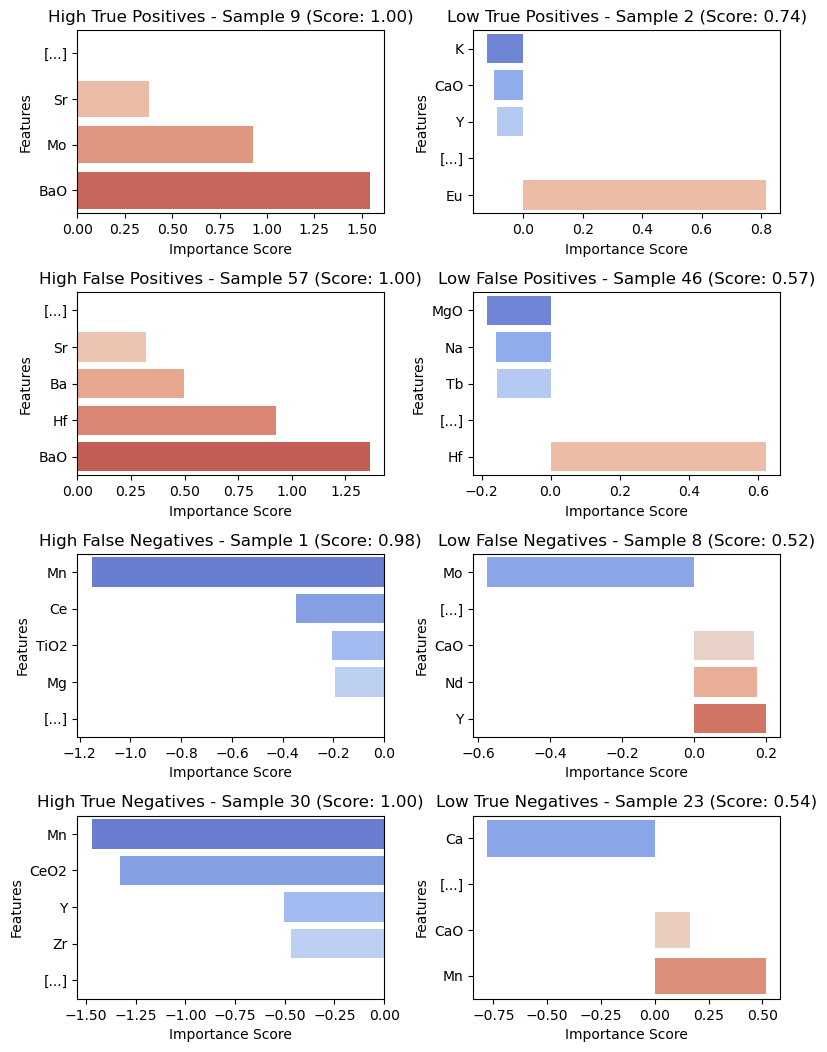

In [36]:
## Visualize the relevance scores for the highest and lowest scoring samples per category
# figsize=(8.27, 11.69) is A4 paper size -> lets make it a bit smaller
new_rels_splits = new_rels.reshape(len(split_test_data), -1, new_rels.shape[-1])
new_rels_single_split = new_rels_splits[single_sample_split_rs]
for rel_key, rels_list in rels.items():
    if rel_key == 'R_on_pred':
        continue
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 10.95))
    axes = axes.flatten()
    for k, (index_list, score_list, category) in enumerate(zip(index_lists, score_lists, categories)):
        print('index list ', index_list)
        print('score list', score_list)
        print('out_pos', np.sum(out_list[out_list>0]))
        print('out_neg', np.sum(out_list[out_list<0]))
        print('old_rels', rels_list[idx][rels_list[idx] != 0])
        print('new_rels', new_rels_single_split[idx][new_rels_single_split[idx] != 0])
        print()
        idx = index_list[0]
        score = score_list[0]
        # rels_single_sample = rels_list[idx]  # Is a list with feature relevance scores for given sample
        rels_single_sample = new_rels_single_split[idx]

        df_single_sample = pd.DataFrame({
            'Feature': feature_names,
            'Importance Score': rels_single_sample
        }).sort_values(by='Importance Score', ascending=True)

        # Find the index of the first zero value
        zero_index = df_single_sample['Importance Score'].eq(0).idxmax()

        df_single_sample = df_single_sample[
            ~((df_single_sample['Importance Score'] == 0) & (df_single_sample.index != zero_index))]
        df_single_sample.loc[zero_index, 'Feature'] = '[...]'

        palette = custom_palette(df_single_sample['Importance Score'])

        sns.barplot(x='Importance Score', y='Feature', data=df_single_sample, palette=palette, ax=axes[k])
        axes[k].set_title(f"{category} - Sample {idx} (Score: {score:.2f})", fontsize=12)
        axes[k].set_xlabel('Importance Score')
        axes[k].set_ylabel('Features')
    # fig.suptitle(
    #     f"Feature Importance Scores for Highest and Lowest Scoring Samples\n(Relevances computed w.r.t. {'prediction' if 'pred' in rel_key else 'the positive class'})",
    #     fontsize=13)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    if SAVE:
        plt.savefig(
            storing_path / f"LRP_on_{'prediction' if 'pred' in rel_key else 'positive_class'}_samples_per_cat_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0),
            bbox_inches='tight')
    plt.show(fig)

# Plot with Rebalancing Factor

Relevance scores for R_on_pos_cls shape: (100, 59, 36) (n_splits, n_samples, n_features)


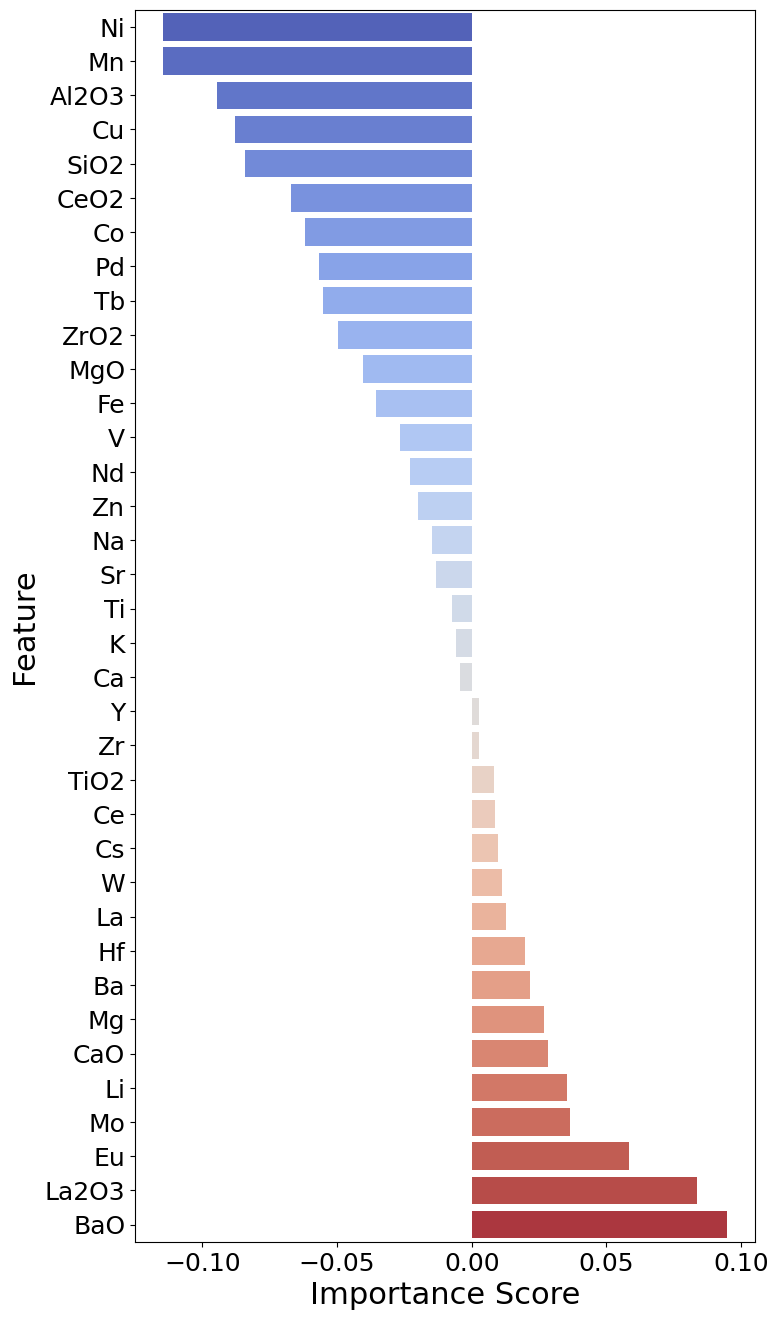

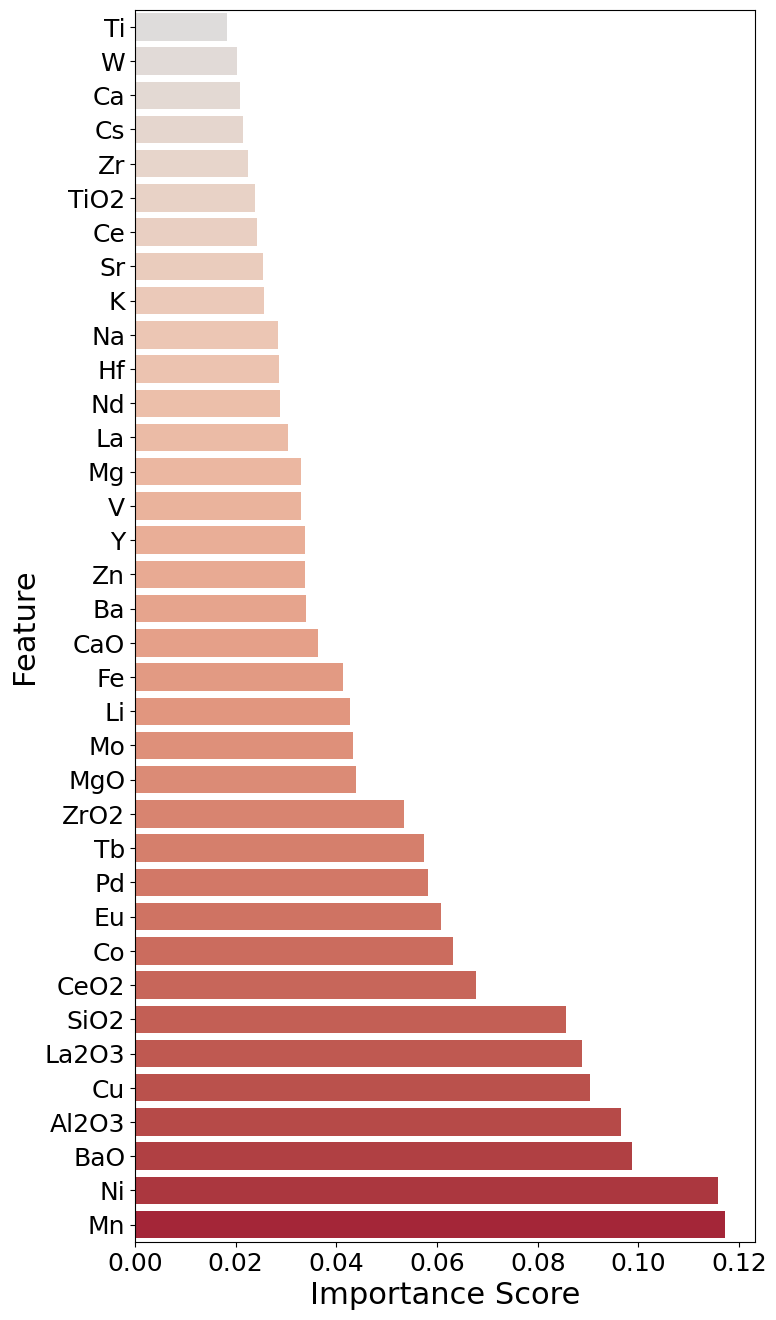

In [84]:
for rel_key in ['R_on_pos_cls']:

    rels_per_split_n_sample = np.array([rs_data['rels'][rel_key] for rs, rs_data in split_test_data.items()])
    if verbose:
        print(
            f"Relevance scores for {rel_key} shape: {rels_per_split_n_sample.shape} (n_splits, n_samples, n_features)")

    # flatten the array such that the rows are all samples over all splits
    flattened_array = new_rels

    # compute mean relevance over all samples and splits
    mean_relevance = flattened_array.mean(axis=0)
    mean_abs_relevance = np.abs(flattened_array).mean(axis=0)

    df_feature_importance_nn = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': mean_relevance,
    })

    # store mean feature importances 
    if SAVE:
        file_path_nn = f"feature_importance_nn_WithRebalancing_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.csv"
        df_feature_importance_nn.to_csv(storing_path / file_path_nn, index=False)

    df_feature_importance_sorted = df_feature_importance_nn.sort_values(by='Importance Score', ascending=True)

    # Plot the sorted feature importance
    plt.figure(figsize=(8, 16))
    palette = custom_palette(df_feature_importance_sorted['Importance Score'])

    sns.barplot(x='Importance Score', y='Feature', data=df_feature_importance_sorted, palette=palette)
    #plt.title(
    #    f"Feature Importance in Neural Networks (LRP based on the {'prediction with Bias No Layer Norm' if 'pred' in rel_key else 'positive class with Bias No Layer Norm'})")
    plt.xlabel('Importance Score', fontsize=22)
    plt.ylabel('Feature', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if SAVE:
        plt.savefig(
            storing_path / f"feature_importance_nn_WithRebalancing_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0),
            bbox_inches='tight')
    plt.show()

    # Plot the absolute values of the sorted feature importance
    df_feature_importance_nn_abs = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': mean_abs_relevance,
    })

    df_feature_importance_nn_abs_sorted = df_feature_importance_nn_abs.sort_values(by='Importance Score',
                                                                                   ascending=True)

    plt.figure(figsize=(8, 16))
    palette = custom_palette(df_feature_importance_nn_abs_sorted['Importance Score'])

    sns.barplot(x='Importance Score', y='Feature', data=df_feature_importance_nn_abs_sorted, palette=palette)
    #plt.title(
    #    f"Absolute Feature Importance in Neural Networks (LRP based on the {'prediction' if 'pred' in rel_key else 'positive class'})")
    plt.xlabel('Importance Score', fontsize=22)
    plt.ylabel('Feature', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if SAVE:
        plt.savefig(
            storing_path / f"feature_importance_nn_abs_WithRebalancing_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0), bbox_inches='tight')
    plt.show()

        # store mean feature importances 
    if SAVE:
        file_path_nn = f"feature_importance_nn_abs_WithRebalancing_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.csv"
        df_feature_importance_nn.to_csv(storing_path / file_path_nn, index=False)

    df_feature_importance_sorted = df_feature_importance_nn.sort_values(by='Importance Score', ascending=True)

In [85]:
ratio_pos2neg = []
for key in split_test_data.keys():
    split = split_test_data[key]
    #split_array = np.array(split['rels']['R_on_pos_cls'])
    split_array = new_rels


    pos_element = np.sum(split_array[split_array > 0])
    neg_element = np.sum(np.abs(split_array[split_array < 0]))
    #print(f"pos/neg: {pos_element/neg_element}")
    ratio_pos2neg.append(pos_element/neg_element)
print("ratio mean: ", np.mean(ratio_pos2neg))

ratio mean:  0.5437965654498578


Relevance scores for R_on_pos_cls shape: (100, 59, 36) (n_splits, n_samples, n_features)
(2200, 36)


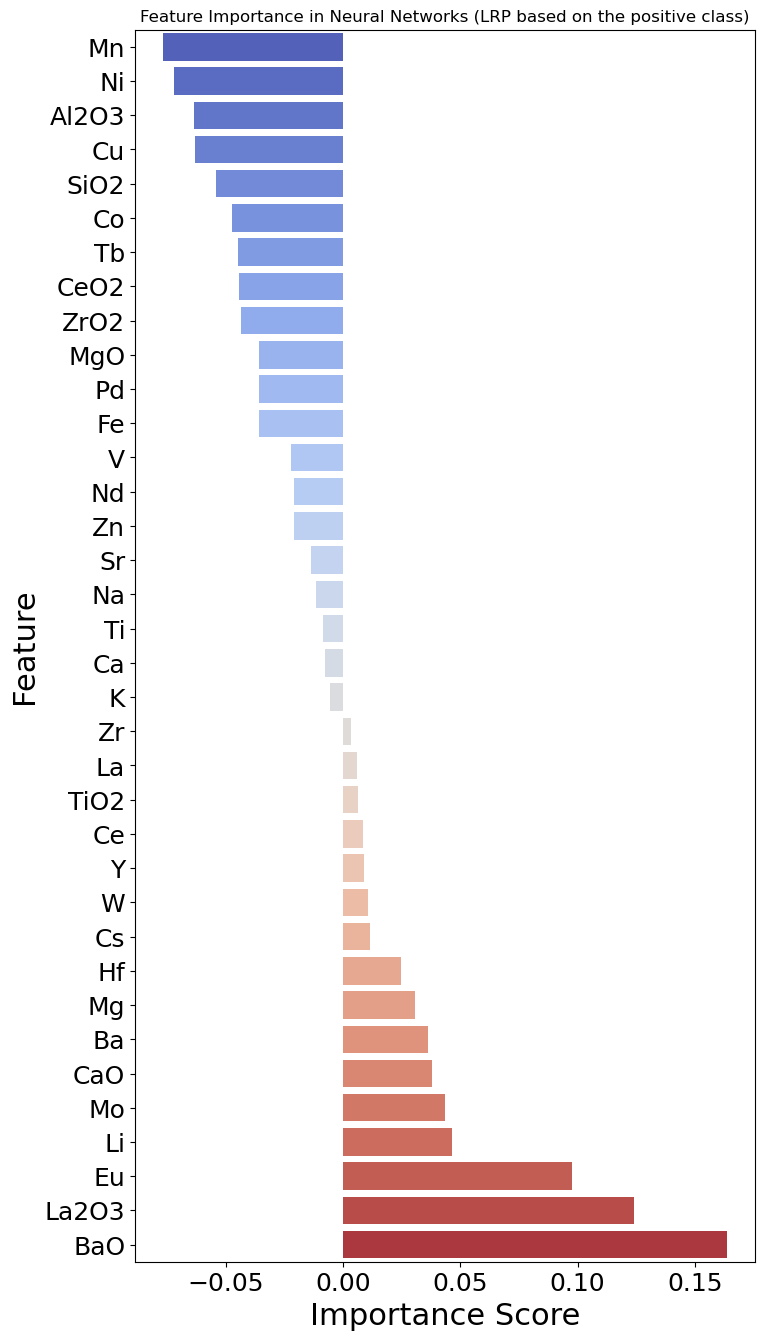

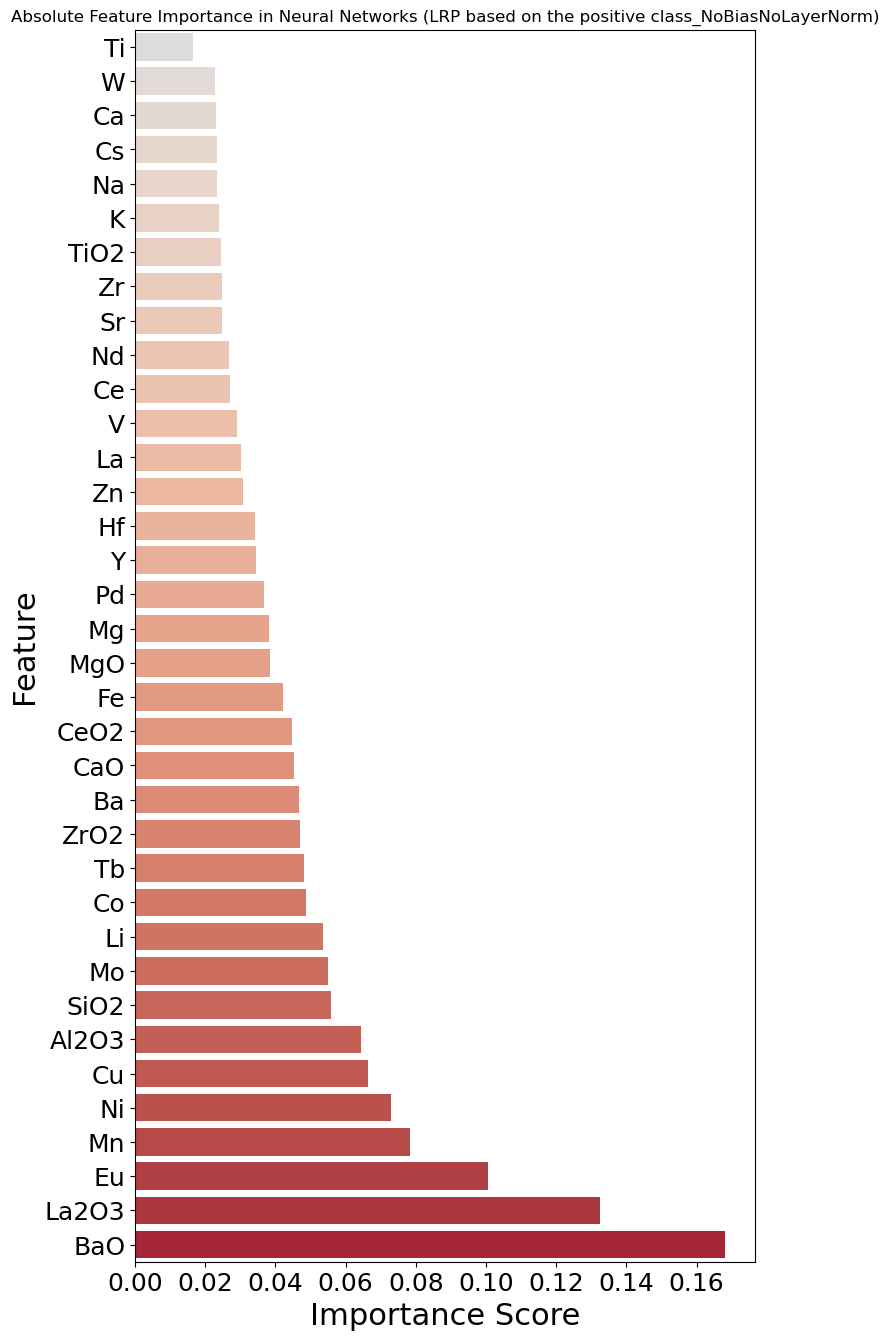

In [86]:
# Resampled data
for rel_key in ['R_on_pos_cls']:

    rels_per_split_n_sample = np.array([rs_data['rels'][rel_key] for rs, rs_data in split_test_data.items()])
    rels_per_split_n_sample = new_rels.reshape(rels_per_split_n_sample.shape)
    # rels_per_split_n_sample = new_rels
    if verbose:
        print(
            f"Relevance scores for {rel_key} shape: {rels_per_split_n_sample.shape} (n_splits, n_samples, n_features)")

    # flatten the array such that the rows are all samples over all splits
    gt_per_split_n_sample = [rs_data['gt'] for rs, rs_data in split_test_data.items()]
    rels_per_split_n_resampled = []
    gt_per_split_n_resampled = []
    for i in range(len(gt_per_split_n_sample)):
        pos_num = np.sum(gt_per_split_n_sample[i])
        neg_idx = np.where(gt_per_split_n_sample[i] == 0)[0]
        neg_select = np.random.choice(neg_idx, pos_num, replace=False)
        pos_select = np.where(gt_per_split_n_sample[i] == 1)[0]
        select = np.concatenate((pos_select, neg_select))
        gt_per_split_n_resampled.append(gt_per_split_n_sample[i][select])
        rels_per_split_n_resampled.append(rels_per_split_n_sample[i][select])

    # flatten a nested list
    rels_per_split_n_resampled_array = np.array([rel for rels in rels_per_split_n_resampled for rel in rels])
    gt_per_split_n_resampled_array = np.array([gt for gts in gt_per_split_n_resampled for gt in gts])

    flattened_array = rels_per_split_n_resampled_array
    #print(flattened_array.shape)

    # compute mean relevance over all samples and splits
    mean_relevance = flattened_array.mean(axis=0)
    mean_abs_relevance = np.abs(flattened_array).mean(axis=0)

    df_feature_importance_rebalanced = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': mean_relevance,
    })

    # store mean feature importances 
    if SAVE:
        file_path_nn = f"feature_importance_nn_WithRebalancing_Resampled_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.csv"
        df_feature_importance_rebalanced.to_csv(storing_path / file_path_nn, index=False)

    df_feature_importance_sorted = df_feature_importance_rebalanced.sort_values(by='Importance Score', ascending=True)

    # Plot the sorted feature importance
    plt.figure(figsize=(8, 16))
    palette = custom_palette(df_feature_importance_sorted['Importance Score'])

    sns.barplot(x='Importance Score', y='Feature', data=df_feature_importance_sorted, palette=palette)
    plt.title(
        f"Feature Importance in Neural Networks (LRP based on the {'prediction' if 'pred' in rel_key else 'positive class'})")
    plt.xlabel('Importance Score', fontsize=22)
    plt.ylabel('Feature', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if SAVE:
        plt.savefig(
            storing_path / f"feature_importance_nn_WithRebalancing_Resampled_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0),
            bbox_inches='tight')
    plt.show()

    # Plot the absolute values of the sorted feature importance
    df_feature_importance_nn_abs = pd.DataFrame({
        'Feature': feature_names,
        'Importance Score': mean_abs_relevance,
    })

    df_feature_importance_nn_abs_sorted = df_feature_importance_nn_abs.sort_values(by='Importance Score',
                                                                                   ascending=True)

    plt.figure(figsize=(8, 16))
    palette = custom_palette(df_feature_importance_nn_abs_sorted['Importance Score'])

    sns.barplot(x='Importance Score', y='Feature', data=df_feature_importance_nn_abs_sorted, palette=palette)
    plt.title(
        f"Absolute Feature Importance in Neural Networks (LRP based on the {'prediction_NoBias_NoLayerNorm_OutAct' if 'pred' in rel_key else 'positive class_NoBiasNoLayerNorm'})")
    plt.xlabel('Importance Score', fontsize=22)
    plt.ylabel('Feature', fontsize=22)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if SAVE:
        plt.savefig(
            storing_path / f"feature_importance_nn_abs_WithRebalancing_Resampled_{'prediction' if 'pred' in rel_key else 'positive_class_rebalanced'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.png",
            dpi=300, facecolor=(1, 1, 1, 0), bbox_inches='tight')
    plt.show()
    if SAVE:
        file_path_nn = f"feature_importance_nn_abs_WithRebalancing_Resampled_{'prediction' if 'pred' in rel_key else 'positive_class'}_bias_{bias}_art_neuron_{act_rel}_wd_{wd}.csv"
        df_feature_importance_nn.to_csv(storing_path / file_path_nn, index=False)

In [87]:
ratio_pos2neg = []
for key in split_test_data.keys():
    split = split_test_data[key]
    #split_array = np.array(split['rels']['R_on_pos_cls'])
    split_array = rels_per_split_n_resampled_array

    pos_element = np.sum(split_array[split_array > 0])
    neg_element = np.sum(np.abs(split_array[split_array < 0]))
    #print(f"pos/neg: {pos_element/neg_element}")
    ratio_pos2neg.append(pos_element/neg_element)
print("ratio mean: ", np.mean(ratio_pos2neg))

ratio mean:  0.9239643395704978


### MLP

In [54]:
from relevance_based_candidate import create_catalyst_from_relevance_scores, catalyst_string_to_numpy

candidates = create_catalyst_from_relevance_scores(df_feature_importance_rebalanced['Importance Score'].to_numpy(),
                                                   df_feature_importance_rebalanced['Feature'].to_list(),
                                                   num_candidates=1000, elem_importance_factor=25,
                                                   supp_importance_factor=4,
                                                   )
#print('candidates', candidates)

[Errno 2] No such file or directory: '/home/mihail/Documents/workspace/MLforCatalyst/OCM/'
/Users/parastoo/phd_projects/OCM/Robustness check & alternative methods
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
elements num 27
supports num 9
elem_names ['Ba', 'Ca', 'Ce', 'Co', 'Cs', 'Cu', 'Eu', 'Fe', 'Hf', 'K', 'La', 'Li', 'Mg', 'Mn', 'Mo', 'Na', 'Nd', 'Ni', 'Pd', 'Sr', 'Tb', 'Ti', 'V', 'W', 'Y', 'Zn', 'Zr']
elem_scores [  1.5594246   -0.97017103   0.3564273   -4.0031013    0.50492114
  -4.0179453    2.9256783   -2.276944     1.7075406   -7.1162076
 -45.308544     2.1521664    0.14492378  -6.950064     2.0780425
  -1.0410573   -1.8585463   -6.978047    -4.414917    -1.065872
  -3.6119304   -0.57401854  -0.81070113  14.406069     0.38094112
  -1.5548364    0.18925436]
Al2O3 : 5.5912566 0.96850675
BaO : 0.8745852 0.008663199
CaO : 0.20171931 0.0044203466
CeO2 : -0.62031245 0.0019429094
La2O3 : 0.67057496 0.0070644417
MgO : -0.6396871 0.0019056284
S

In [55]:
feats = catalyst_string_to_numpy(candidates,
                                    df_feature_importance_rebalanced['Feature'].to_list(),
                                    remove_duplicates=True)

print('feats.shape', feats.shape)
logits = max_f1_model(torch.from_numpy(feats).float())
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)  # Get the predicted class
#print('prediction', y_pred)
print('fraction of samples predicted as true', float(torch.sum(y_pred) / y_pred.shape[0]))

feats.shape (135, 36)
fraction of samples predicted as true 0.39259257912635803


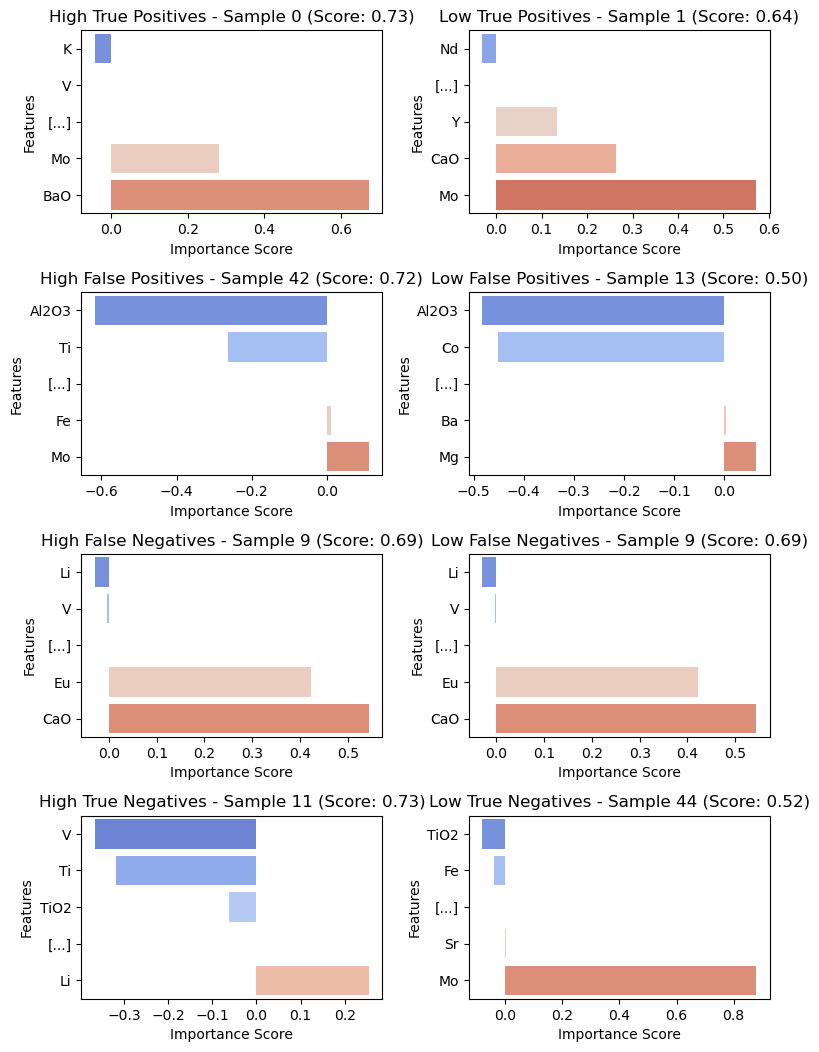

In [42]:
def plot_feature_importance_distribution(feature_importances, feature_names, model_name, color='gray'):
    """
    This function processes feature importances, sorts them, and plots a boxplot that can be colored based on importance.
    The values are NOT normalized.

    Parameters:
    - feature_importances (np.array): 2D array of feature importances from different splits/models.
    - feature_names (list): List of feature names.
    - model_name (str): Name of the model for titling the plot.
    - color (str): Color mode for the plot ('gray' for neutral, 'rainbow' for colored based on importance).

    Returns:
    - None, but displays a plot.
    """
# Convert to NumPy array if not already
    feature_importance_values = np.array(feature_importances)

# Calculate mean importance values for each feature
    mean_importance_values = np.mean(feature_importance_values, axis=0)

# Sort features based on average importance values
    sorted_indices = np.argsort(mean_importance_values)[::-1]
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    sorted_feature_importance_values = feature_importance_values[:, sorted_indices]

# Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    boxes = ax.boxplot(sorted_feature_importance_values, vert=False, patch_artist=True)
    ax.set_title(f'Sorted Absolute Feature Importance Distribution for {model_name}')

# Color handling
    if color == 'rainbow':
        colors = plt.cm.rainbow(mean_importance_values[sorted_indices] / np.max(mean_importance_values))
        for box, color in zip(boxes['boxes'], colors):
            box.set_facecolor(color)
        # Colorbar
        sm = ScalarMappable(cmap=plt.cm.rainbow, norm=plt.Normalize(vmin=np.min(mean_importance_values), vmax=np.max(mean_importance_values)))
        cbar = plt.colorbar(sm, orientation='vertical', pad=0.05)
        cbar.set_label('Mean Importance')
    else:
        for box in boxes['boxes']:
            box.set_facecolor(color)  # Default color is 'gray'

# Labeling
    ax.set_xlabel('Feature Importance', fontsize=16, fontweight='bold')
    ax.set_ylabel('Features', fontsize=16, fontweight='bold')
    ax.set_yticks(np.arange(1, len(sorted_feature_names) + 1))
    ax.set_yticklabels(sorted_feature_names, fontsize=10, fontweight='bold')
    plt.savefig(storing_path / f'FI_{model_name}_dist.png')
    plt.show()

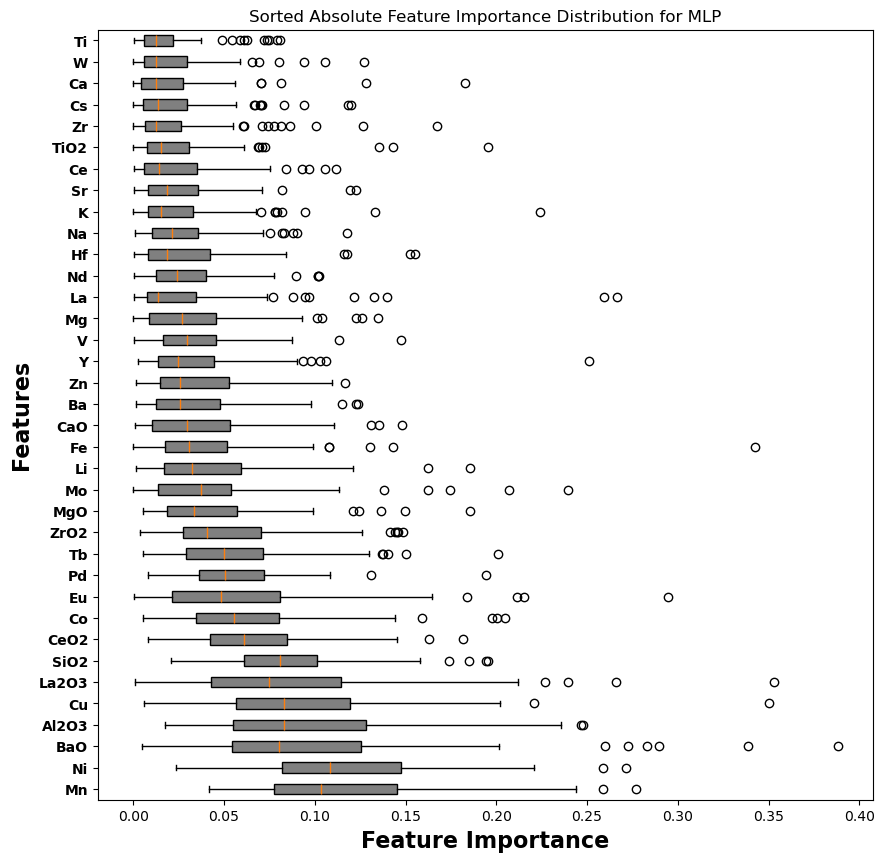

In [43]:
plot_feature_importance_distribution(np.abs(new_rels_splits).mean(1), feature_names, 'MLP')